## Setup

In [1]:
source("/path/to/the/project/02_notebooks/00_setup.r")

In [2]:
p_load("DESeq2", "dplyr", "ashr", "DEGreport", "ggplot2", "maSigPro", "fgsea", "ComplexUpset", install = FALSE)

In [3]:
metadata <- read.csv("2022_08_12_CDL_regression_sample_annotation.csv", row.names = 1)
data <- read.csv("03_outputs/02/count_matrix_annotated.csv", row.names = 1)
count_matrix <- data 
metadata <- metadata %>% tidyr::unite("Model_group", Model:Group, remove = FALSE)
metadata <- metadata %>% tibble::column_to_rownames(var="Sample_id")
metadata$Group <- as.factor(metadata$Group)
metadata$Group <- relevel(metadata$Group, "Cpos")
metadata$Group <- relevel(metadata$Group, "Cneg")

In [4]:
dds_intercept <- DESeqDataSetFromMatrix(countData = count_matrix, colData = metadata,
  design = ~Model_group)
dds_intercept <- DESeq(dds_intercept, test="LRT", reduced = ~ 1)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [5]:
Cneg <- c("CDL_0002", "CDL_0003", "CDL_0007", "CDL_0008", "CDL_0009", "CDL_0011", "CDL_0084", "CDL_0086", "CDL_0088", "CDL_0089", "CDL_0090", "CDL_0091")
Cpos <- c("CDL_0036", "CDL_0037", "CDL_0038", "CDL_0039", "CDL_0040", "CDL_0041", "CDL_0116", "CDL_0117", "CDL_0118", "CDL_0120", "CDL_0121", "CDL_0123")
Reg <- c("CDL_0044", "CDL_0045", "CDL_0046", "CDL_0048", "CDL_0049", "CDL_0050", "CDL_0052", "CDL_0054", "CDL_0055", "CDL_0056", "CDL_0057", "CDL_0058")
Reg2 <- c("CDL_0124", "CDL_0125", "CDL_0126", "CDL_0127", "CDL_0128", "CDL_0131", "CDL_0132", "CDL_0133", "CDL_0134", "CDL_0135", "CDL_0137", "CDL_0138")

## Differential expression

### Intercept

In [20]:
res_intercept <- results(dds_intercept)

In [21]:
res_intercept_tb <- res_intercept %>%
  data.frame() %>%
  tibble::rownames_to_column(var="gene") %>% 
  as_tibble()

In [22]:
intercept_genes_sig <- res_intercept_tb %>% 
  filter(padj < 0.05)

nrow(intercept_genes_sig)

[1] 15468

In [23]:
intercept_genes_sig <- intercept_genes_sig %>%
  arrange(padj) %>%
  head(n=3000)

In [24]:
intercept_preprocessed <- assay(dds_intercept)[intercept_genes_sig$gene, ]

In [25]:
intercept_preprocessed <- varianceStabilizingTransformation(intercept_preprocessed)

Working with 3000 genes.

Working with 3000 genes after filtering: minc > 15

Joining with `by = join_by(merge)`
Joining with `by = join_by(merge)`


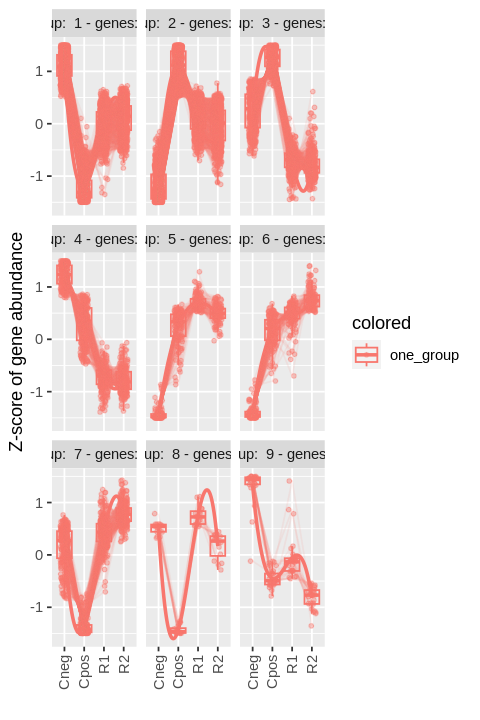

In [26]:
clusters_intercept <- degPatterns(intercept_preprocessed, metadata = metadata, time = "Group", , col=NULL)
# ref: https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-020-20323-9/MediaObjects/41467_2020_20323_Fig1_HTML.png

In [27]:
groups_intercept <- clusters_intercept$df

#### Visualization

In [29]:
up_down <- groups_intercept %>% filter(cluster %in% c(2, 3))
up_up <- groups_intercept %>% filter(cluster %in% c(5, 6))
down_up <- groups_intercept %>% filter(cluster %in% c(1, 7, 8))
down_down <- groups_intercept %>% filter(cluster %in% c(4, 9))

In [31]:
gene_mtx <- assay(dds_intercept)
gene_mtx <- varianceStabilizingTransformation(gene_mtx)
cneg_v_mtx <- gene_mtx[, Cneg]
cpos_v_mtx <- gene_mtx[, Cpos]
reg_v_mtx <- gene_mtx[, Reg]
reg2_v_mtx <- gene_mtx[, Reg2]


In [32]:
cneg_v_mtx <- cneg_v_mtx %>% rowMeans() %>% as.data.frame() %>% rename(HC = ".") %>% tibble::rownames_to_column("gene")
cpos_v_mtx <- cpos_v_mtx %>% rowMeans() %>% as.data.frame() %>% rename(CIR = ".") %>% tibble::rownames_to_column("gene")
reg_v_mtx <- reg_v_mtx %>% rowMeans() %>% as.data.frame() %>% rename(R1 = ".") %>% tibble::rownames_to_column("gene")
reg2_v_mtx <- reg2_v_mtx %>% rowMeans() %>% as.data.frame() %>% rename(R2 = ".") %>% tibble::rownames_to_column("gene")

In [33]:
dynamics_merge <- merge(cneg_v_mtx, cpos_v_mtx, by = "gene", all = T) %>% merge(., reg_v_mtx, by = "gene", all = T) %>% merge(., reg2_v_mtx, by = "gene", all = T)

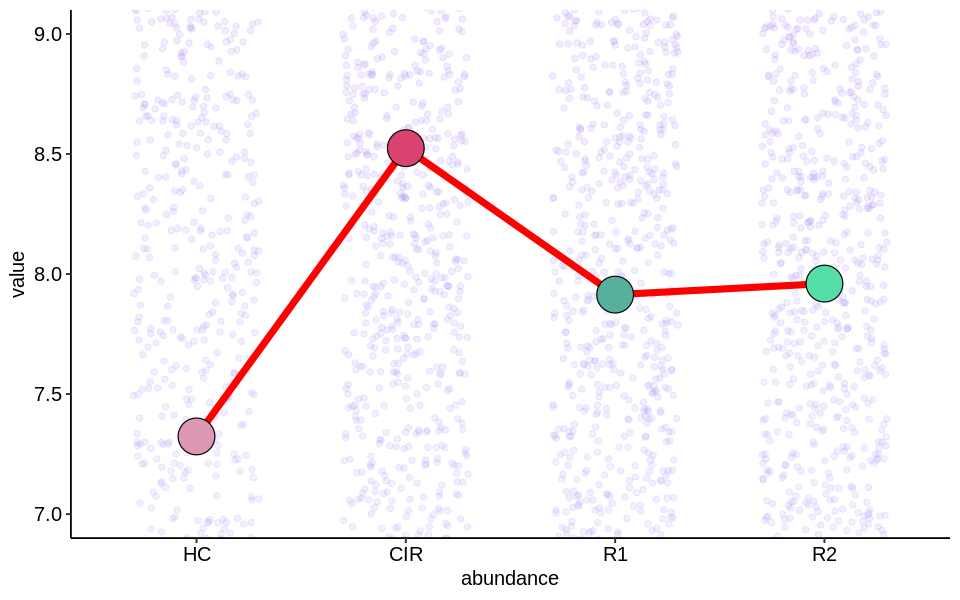

In [126]:
options(repr.plot.width = 8, repr.plot.height = 5)
dynamics_merge %>% filter(gene %in% up_down$gene) %>% tidyr::gather(., abundance, value, HC:R2, factor_key = TRUE) %>%
          #      mutate(value = scale(value)) %>%
                ggplot(., aes(x = value, y = abundance, color = value)) + geom_jitter(alpha = .15, position = position_jitter(width = 0.5, height = 0.3)) + 
                stat_summary(aes(y = abundance,group=1), fun.y=mean, colour="red", geom="line",group=1, size = 2) + 
                stat_summary(aes(y = abundance,group=1, fill = abundance), fun.y=mean, geom="point",group=1, size = 10, pch=21) +
                ggpubr::theme_pubr() + theme(legend.position = "none") + 
                scale_color_gradient(
                  low = "#AEBAF8", 
                  high = "#9600FF"
                   ) +
                   scale_fill_manual(values=c("#dc97b3", "#da4370", "#57b09c", "#55dfa7")) +
                   coord_flip(xlim = c(7, 9)) #+ coord_flip()
                  # scale_x_continuous(breaks = scales::pretty_breaks(n = 2))

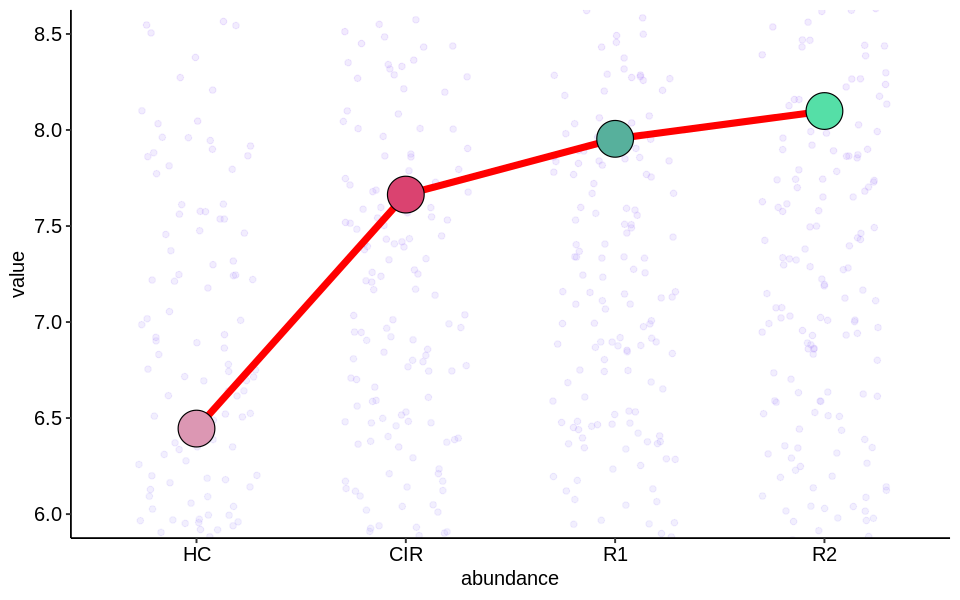

In [127]:
options(repr.plot.width = 8, repr.plot.height = 5)
dynamics_merge %>% filter(gene %in% up_up$gene) %>% tidyr::gather(., abundance, value, HC:R2, factor_key = TRUE) %>%
          #      mutate(value = scale(value)) %>%
                ggplot(., aes(x = value, y = abundance, color = value)) + geom_jitter(alpha = .15, position = position_jitter(width = 0.5, height = 0.3)) + 
                stat_summary(aes(y = abundance,group=1), fun.y=mean, colour="red", geom="line",group=1, size = 2) + 
                stat_summary(aes(y = abundance,group=1, fill = abundance), fun.y=mean, geom="point",group=1, size = 10, pch=21) +
                coord_flip(xlim = c(6, 8.5)) + ggpubr::theme_pubr() + theme(legend.position = "none") + 
                scale_color_gradient(
                  low = "#AEBAF8", 
                  high = "#9600FF"
                   ) +
                   scale_fill_manual(values=c("#dc97b3", "#da4370", "#57b09c", "#55dfa7")) +
                   scale_x_continuous(breaks = scales::pretty_breaks(n = 5))

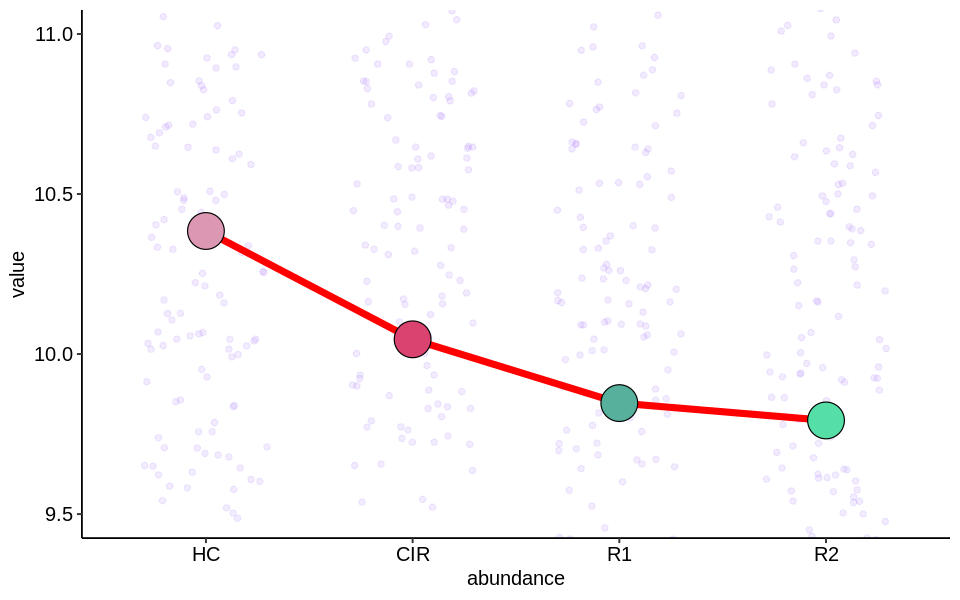

In [128]:
options(repr.plot.width = 8, repr.plot.height = 5)
dynamics_merge %>% filter(gene %in% down_down$gene) %>% tidyr::gather(., abundance, value, HC:R2, factor_key = TRUE) %>%
          #      mutate(value = scale(value)) %>%
                ggplot(., aes(x = value, y = abundance, color = value)) + geom_jitter(alpha = .15, position = position_jitter(width = 0.5, height = 0.3)) + 
                stat_summary(aes(y = abundance,group=1), fun.y=mean, colour="red", geom="line",group=1, size = 2) + 
                stat_summary(aes(y = abundance,group=1, fill = abundance), fun.y=mean, geom="point",group=1, size = 10, pch=21) +
                coord_flip(xlim = c(9.5, 11)) + ggpubr::theme_pubr() + theme(legend.position = "none") + 
                scale_color_gradient(
                  low = "#AEBAF8", 
                  high = "#9600FF"
                   ) +
                   scale_fill_manual(values=c("#dc97b3", "#da4370", "#57b09c", "#55dfa7")) +
                   scale_x_continuous(breaks = scales::pretty_breaks(n = 5))

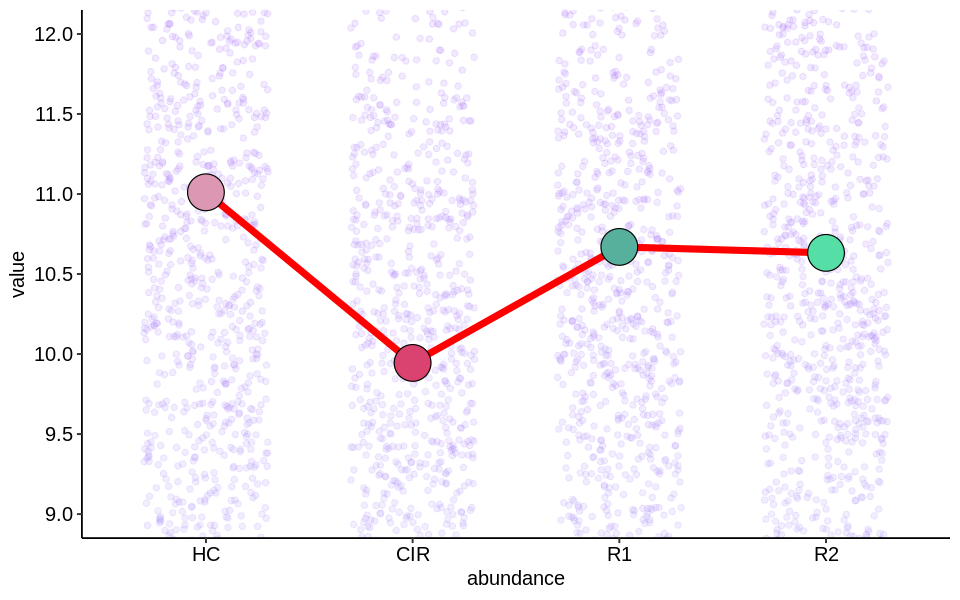

In [129]:
options(repr.plot.width = 8, repr.plot.height = 5)
dynamics_merge %>% filter(gene %in% down_up$gene) %>% tidyr::gather(., abundance, value, HC:R2, factor_key = TRUE) %>%
          #      mutate(value = scale(value)) %>%
                ggplot(., aes(x = value, y = abundance, color = value)) + geom_jitter(alpha = .15, position = position_jitter(width = 0.5, height = 0.3)) + 
                stat_summary(aes(y = abundance,group=1), fun.y=mean, colour="red", geom="line",group=1, size = 2) + 
                stat_summary(aes(y = abundance,group=1, fill = abundance), fun.y=mean, geom="point",group=1, size = 10, pch=21) +
                coord_flip(xlim = c(9, 12)) + ggpubr::theme_pubr() + theme(legend.position = "none") + 
                scale_color_gradient(
                  low = "#AEBAF8", 
                  high = "#9600FF"
                   ) +
                   scale_fill_manual(values=c("#dc97b3", "#da4370", "#57b09c", "#55dfa7")) +
                   scale_x_continuous(breaks = scales::pretty_breaks(n = 5))

### UpSetR from Wald + pseudotemporal genes

In [47]:
ccl4_cpos_cneg <- read.csv("03_outputs/03/de_ccl4_cpos_cneg_sig_wald.csv")
ccl4_reg_cpos <- read.csv("03_outputs/03/de_ccl4_reg_pos_sig_wald.csv")
taa_cpos_cneg <- read.csv("03_outputs/03/de_taa_cpos_cneg_sig_wald.csv")
taa_reg_cpos <- read.csv("03_outputs/03/de_taa_reg_pos_sig_wald.csv")
ccl4_taa_cpos <- read.csv("03_outputs/03/res_ccl4_taa_cir.csv")
ccl4_taa_r1 <- read.csv("03_outputs/03/res_ccl4_taa_r1_r1.csv")

In [49]:
listInput <- list(`CCL4: CIR vs HC` = ccl4_cpos_cneg$X,
                  `CCL4: R vs CIR` = ccl4_reg_cpos$X,
                  `TAA: CIR vs HC` = taa_cpos_cneg$X,
                  `TAA: R vs CIR` = taa_reg_cpos$X,
                  `Dynamics: up-down` = up_down$gene,
                  `Dynamics: down-up` = down_up$gene,
                  `Dynamics: up-up` = up_up$gene,
                  `Dynamics: down-down` = down_down$gene)

In [50]:
upset_df <- plyr::ldply(listInput, rbind)

In [87]:
intersect_df <- colnames(upset_df)[2:9087]

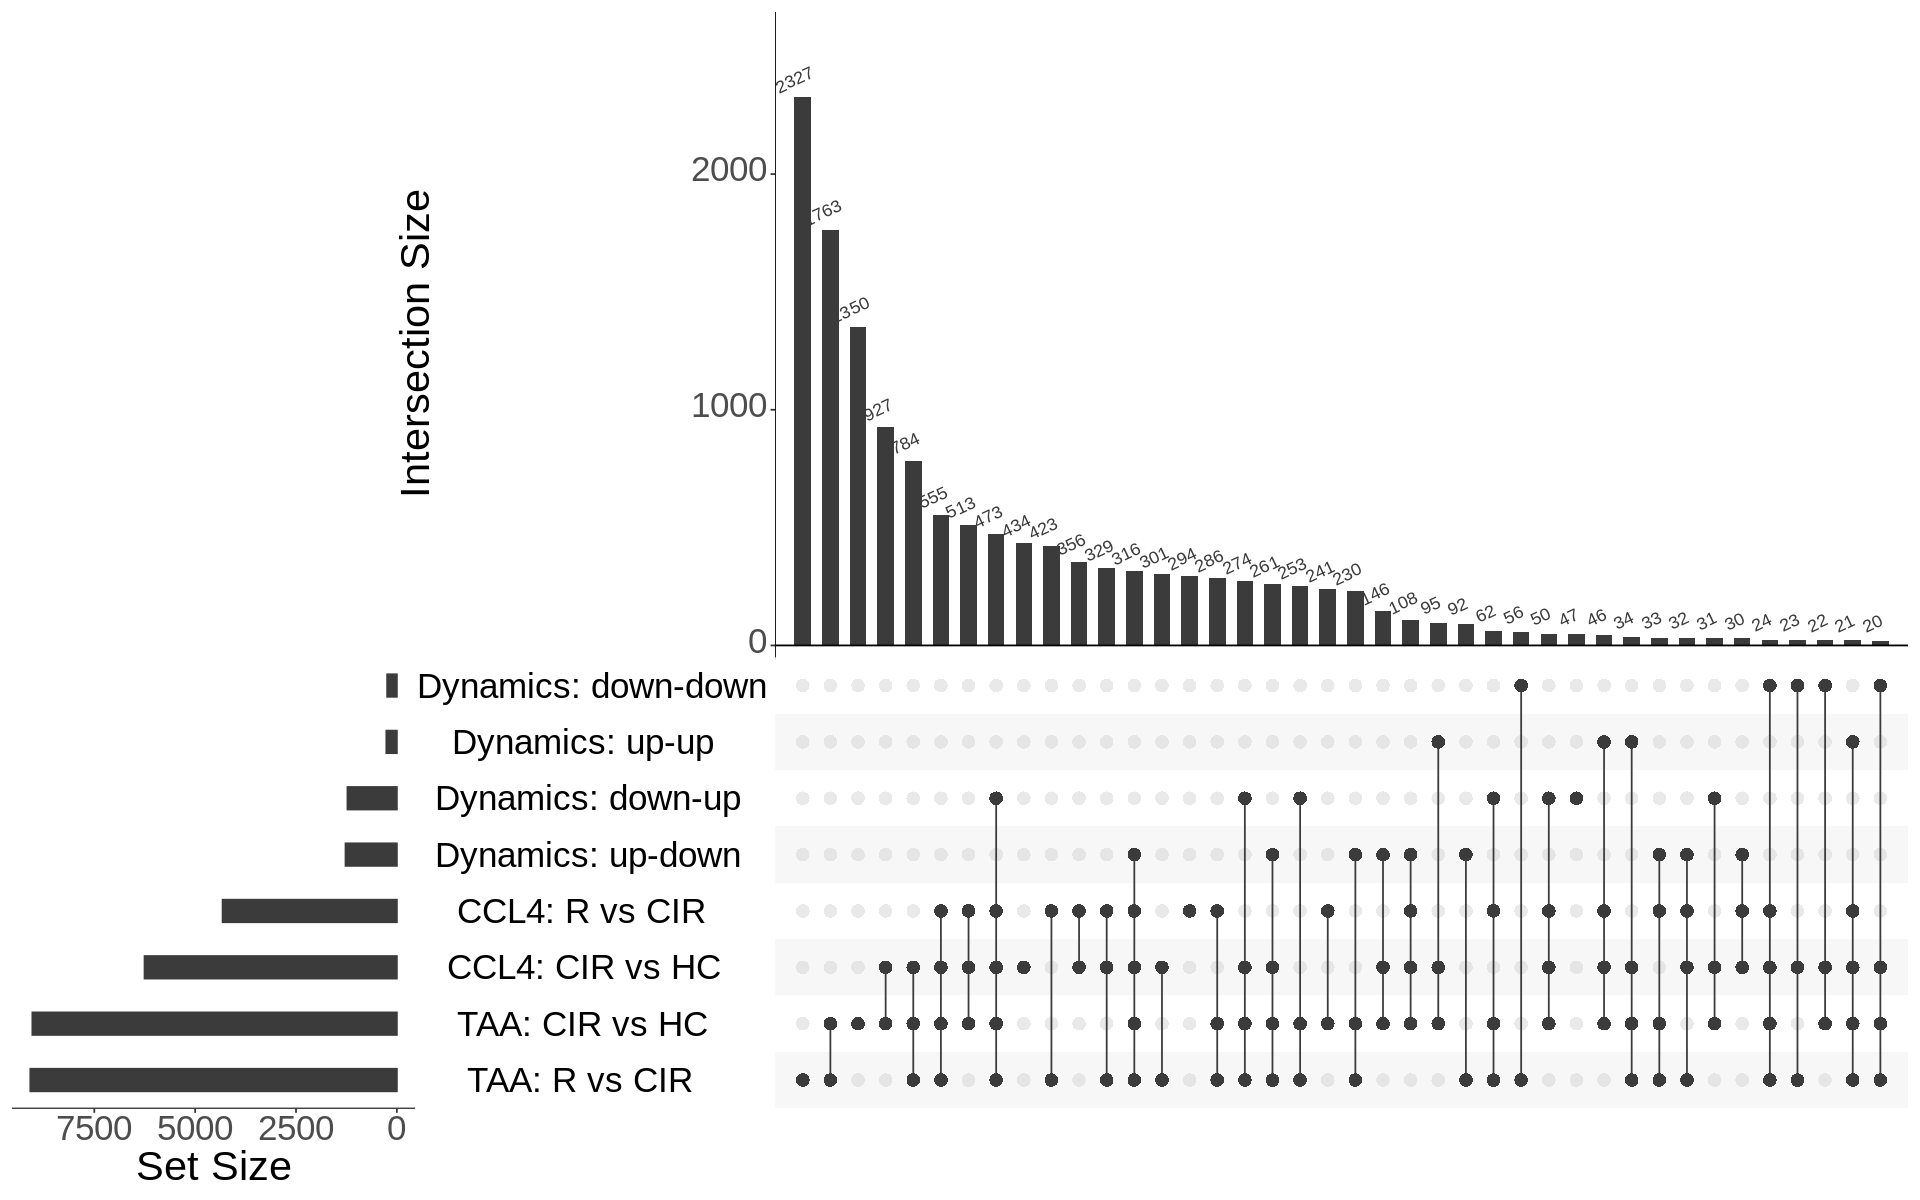

In [104]:
options(repr.plot.width = 16, repr.plot.height = 10)

UpSetR::upset(fromList(listInput), order.by = "freq", keep.order = T,  mb.ratio = c(0.55, 0.45),  nsets = 999, number.angles = 25, point.size = 3.5, line.size = 0.5, text.scale = c(3, 3, 3, 3, 3, 1.7))

### FGSEA

In [53]:
pathways <- gmtPathways("99_technical/m2.cp.wikipathways.v2023.1.Mm.symbols.gmt")
ranks_up_up <- dynamics_merge %>% filter(gene %in% up_up$gene) %>% tidyr::gather(., abundance, value, HC:R2, factor_key = TRUE)  %>% select(gene, value) %>% tibble::deframe()
ranks_up_down <- dynamics_merge %>% filter(gene %in% up_down$gene) %>% tidyr::gather(., abundance, value, HC:R2, factor_key = TRUE)  %>% select(gene, value) %>% tibble::deframe()
ranks_down_up <- dynamics_merge %>% filter(gene %in% down_up$gene) %>% tidyr::gather(., abundance, value, HC:R2, factor_key = TRUE)  %>% select(gene, value) %>% tibble::deframe()
ranks_down_down <- dynamics_merge %>% filter(gene %in% down_down$gene) %>% tidyr::gather(., abundance, value, HC:R2, factor_key = TRUE)  %>% select(gene, value) %>% tibble::deframe()

In [ ]:
fgseaRes_up_up <- fgsea(pathways=pathways, stats=ranks_up_up)
fgseaRes_up_up <- fgseaRes_up_up %>% as.data.frame() %>% arrange(desc(NES)) %>% filter(padj < 0.35)

In [ ]:
fgseaRes_up_up <- fgseaRes_up_up %>% filter(pathway == "WP_FOCAL_ADHESION")

In [ ]:
pathways <- gmtPathways("99_technical/m2.cp.wikipathways.v2023.1.Mm.symbols.gmt")
fgseaRes_up_up <- fgsea(pathways=pathways, stats=ranks_up_up)
fgseaRes_up_down <- fgsea(pathways=pathways, stats=ranks_up_down)

fgseaRes_down_down <- fgsea(pathways=pathways, stats=ranks_down_down)
fgseaRes_down_up <- fgsea(pathways=pathways, stats=ranks_down_up)


fgseaRes_up_up <- fgseaRes_up_up %>% as.data.frame() %>% arrange(desc(NES))
fgseaRes_up_up_save <- apply(fgseaRes_up_up,2,as.character)
write.csv(fgseaRes_up_up_save, "03_outputs/03_2/fgseaRes_up_up.csv")
fgseaRes_up_up <- fgseaRes_up_up %>% dplyr::select(-leadingEdge, -ES) %>% arrange(padj)

fgseaRes_up_down <- fgseaRes_up_down %>% as.data.frame() %>% arrange(desc(NES))
fgseaRes_up_down_save <- apply(fgseaRes_up_down,2,as.character)
write.csv(fgseaRes_up_down_save, "03_outputs/03_2/fgseaRes_up_down.csv")  
fgseaRes_up_down <- fgseaRes_up_down %>% dplyr::select(-leadingEdge, -ES) %>% arrange(padj)

fgseaRes_down_down <- fgseaRes_down_down %>% as.data.frame() %>% arrange(desc(NES)) 
fgseaRes_down_down_save <- apply(fgseaRes_down_down,2,as.character)
write.csv(fgseaRes_down_down_save, "03_outputs/03_2/fgseaRes_down_down.csv")
fgseaRes_down_down <- fgseaRes_down_down %>% dplyr::select(-leadingEdge, -ES) %>% arrange(padj)

fgseaRes_down_up <- fgseaRes_down_up %>% as.data.frame() %>% arrange(desc(NES)) 
fgseaRes_down_up_save <- apply(fgseaRes_down_up,2,as.character)
write.csv(fgseaRes_down_up_save, "03_outputs/03_2/fgseaRes_down_up.csv")
fgseaRes_down_up <- fgseaRes_down_up %>% dplyr::select(-leadingEdge, -ES) %>% arrange(padj)

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6, repr.point.size = 16)
ggplot((fgseaRes_up_down %>% filter(padj < 0.25) %>% arrange(desc(size)) %>% top_n(., 10, size) %>% head(10)), 
    aes(x = reorder(pathway, size), y = size, fill = NES)) +
    geom_bar(stat ="identity", width = 0.5, alpha = 0.8) +
    coord_flip() +
 #   labs(x="Pathways", y="Number of genes", fill="Adjusted P-value (log10)", title = paste0("Pathway enrichment using ", database)) +
    theme(axis.text=element_text(size=20)) + 
    theme(legend.position="none") +
    theme(axis.text.x = element_text(color="black", 
                            size=20),
            axis.text.y = element_text(color="black", 
                            size=20)) +
    theme_light() + scale_fill_gradient(
    low = "#AEBAF8", 
    high = "#9600FF"
    )

In [ ]:
enrichr_to_plot <- function(dataframe, database){
    tmp = dataframe[[database]] %>% top_n(10, wt = Combined.Score) %>% tidyr::separate("Overlap", sep = "/", into = c("Gene_number", "max")) 
    tmp$Gene_number = as.numeric(tmp$Gene_number)
    tmp = tmp %>% arrange(desc(Gene_number))

    options(repr.plot.width=10, repr.plot.height=8, repr.plot.pointsize = 20)

    tf_p <- ggplot(as.data.frame(tmp), aes(x = reorder(Term, Gene_number), y = Gene_number, fill = -log(Adjusted.P.value, base=10))) +
    geom_bar(stat ="identity", width = 0.5, alpha = 0.8) +
    coord_flip() +
    labs(x="Pathways", y="Number of genes", fill="Adjusted P-value (log10)", title = paste0("Pathway enrichment using ", database)) +
    theme(axis.text=element_text(size=20)) + 
    theme(legend.position="none") +
    theme(axis.text.x = element_text(color="black", 
                            size=20),
            axis.text.y = element_text(color="black", 
                            size=20)) +
    theme_light() + scale_fill_gradient(
    low = "#AEBAF8", 
    high = "#9600FF"
    )


tf_p 
}
    

prio_pp <- prioritized_genes %>% filter(module == "PP") %>% select(genes)
prio_pp <- enrichr(prio_pp$gene, dbs)
for (db in dbs){
    plot <- enrichr_to_plot(prio_pp, db)
    print(plot)
}

### ~Model + Group

In [9]:
dds_full_m <- DESeqDataSetFromMatrix(countData = count_matrix, colData = metadata,
  design = ~Model + Group + Model:Group)

dds_lrt_time <- DESeq(dds_full_m, test="LRT", reduced = ~Model + Group)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [10]:
res_LRT_full <- results(dds_lrt_time)

In [16]:
res_LRT_tb_full <- res_LRT_full %>%
  data.frame() %>%
  tibble::rownames_to_column(var="gene") %>% 
  as_tibble()

In [17]:
sigtmp_genes_full <- res_LRT_tb_full %>% 
  filter(padj < 0.001)

# Get number of significant genes
nrow(sigtmp_genes_full)

[1] 7364

In [25]:
sigtmp_genes_full <- sigtmp_genes_full %>%
  arrange(padj) %>%
  head(n=3000)

In [26]:
cluster_genes_full <- assay(dds_lrt_time)[sigtmp_genes_full$gene, ]

In [27]:
cluster_genes_full <- varianceStabilizingTransformation(cluster_genes_full)

Working with 3000 genes.

Working with 2895 genes after filtering: minc > 15

Joining, by = "merge"
Joining, by = "merge"


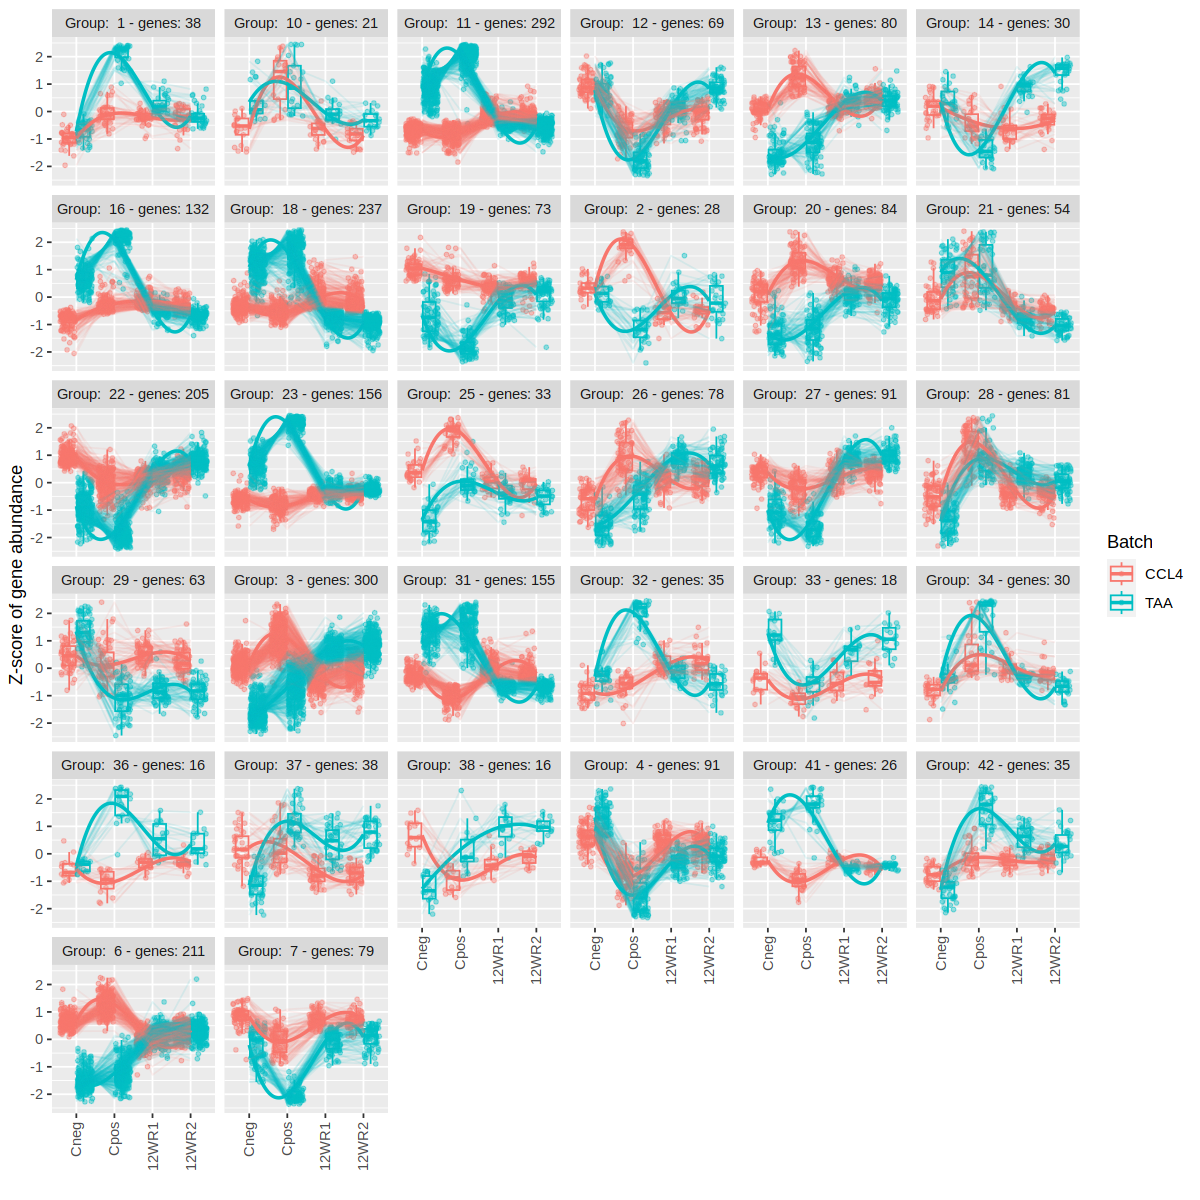

In [28]:
options(repr.plot.width = 10, repr.plot.height = 10)
clusters_full <- degPatterns(cluster_genes_full, metadata = metadata, time="Group", col="Model")

In [29]:
groups_full <- clusters_full$df

## DE lists

In [19]:
dds_lrt_time$Model_group <- as.factor(dds_lrt_time$Model_group)

In [33]:
res_TAA_pos_cneg <- results(dds_lrt_time, contrast = c("Group", "Cpos", "Cneg"))

## Importance scores

### Cirrhosis

In [8]:
model_meta <- metadata 
model_meta$Healthy[model_meta$Group == "Cneg"] <- 1 
model_meta$Healthy[model_meta$Group == "Cpos"] <- 0 
model_meta$Cirrhotic[model_meta$Group == "Cneg"] <- 0 
model_meta$Cirrhotic[model_meta$Group == "Cpos"] <- 1 
model_meta <- model_meta %>% select(Healthy, Cirrhotic) %>% tidyr::drop_na()
model_meta$Tissue <- "Liver"
norm_counts <- counts(dds_intercept, normalized=TRUE)
norm_counts <- norm_counts %>% as.data.frame() %>% select(any_of(rownames(model_meta))) %>% as.matrix()
norm_counts <- norm_counts[ rowSums(norm_counts)!=0, ] 
design <- make.design.matrix(model_meta, degree = 2)
fit <- p.vector(counts(dds_intercept, normalized=TRUE), design, Q = 0.01, MT.adjust = "BH", min.obs = 12)
tstep <- T.fit(fit, step.method = "backward", alfa = 0.01)
cir_score <- tstep$sol %>% select(`R-squared`)

[1] "fitting  gene 100 out of 21350"
[1] "fitting  gene 200 out of 21350"
[1] "fitting  gene 300 out of 21350"
[1] "fitting  gene 400 out of 21350"
[1] "fitting  gene 500 out of 21350"
[1] "fitting  gene 600 out of 21350"
[1] "fitting  gene 700 out of 21350"
[1] "fitting  gene 800 out of 21350"
[1] "fitting  gene 900 out of 21350"
[1] "fitting  gene 1000 out of 21350"
[1] "fitting  gene 1100 out of 21350"
[1] "fitting  gene 1200 out of 21350"
[1] "fitting  gene 1300 out of 21350"
[1] "fitting  gene 1400 out of 21350"
[1] "fitting  gene 1500 out of 21350"
[1] "fitting  gene 1600 out of 21350"
[1] "fitting  gene 1700 out of 21350"
[1] "fitting  gene 1800 out of 21350"
[1] "fitting  gene 1900 out of 21350"
[1] "fitting  gene 2000 out of 21350"
[1] "fitting  gene 2100 out of 21350"
[1] "fitting  gene 2200 out of 21350"
[1] "fitting  gene 2300 out of 21350"
[1] "fitting  gene 2400 out of 21350"
[1] "fitting  gene 2500 out of 21350"
[1] "fitting  gene 2600 out of 21350"
[1] "fitting  gene 27

### Regression

In [9]:
model_meta <- metadata 
model_meta$Cirrhotic[model_meta$isCirrhotic == "no"] <- 0 
model_meta$Cirrhotic[model_meta$isCirrhotic == "yes"] <- 1 
model_meta$Regression[model_meta$Regression == "negative"] <- 0 
model_meta$Regression[model_meta$Regression == "positive"] <- 0 
model_meta$Regression[model_meta$Regression == "regression"] <- 1
model_meta <- model_meta %>% select(Cirrhotic, Regression) %>% tidyr::drop_na()
model_meta$Tissue <- "Liver"
norm_counts <- counts(dds_intercept, normalized=TRUE)
norm_counts_reg <- norm_counts %>% as.data.frame() %>% select(any_of(rownames(model_meta))) %>% as.matrix()
norm_counts <- norm_counts[ rowSums(norm_counts)!=0, ] 
design <- make.design.matrix(model_meta, degree = 2)
fit <- p.vector(counts(dds_intercept, normalized=TRUE), design, Q = 0.01, MT.adjust = "BH", min.obs = 12)
tstep <- T.fit(fit, step.method = "backward", alfa = 0.01)
reg_score <- tstep$sol %>% select(`R-squared`)

[1] "fitting  gene 100 out of 21953"
[1] "fitting  gene 200 out of 21953"
[1] "fitting  gene 300 out of 21953"
[1] "fitting  gene 400 out of 21953"
[1] "fitting  gene 500 out of 21953"
[1] "fitting  gene 600 out of 21953"
[1] "fitting  gene 700 out of 21953"
[1] "fitting  gene 800 out of 21953"
[1] "fitting  gene 900 out of 21953"
[1] "fitting  gene 1000 out of 21953"
[1] "fitting  gene 1100 out of 21953"
[1] "fitting  gene 1200 out of 21953"
[1] "fitting  gene 1300 out of 21953"
[1] "fitting  gene 1400 out of 21953"
[1] "fitting  gene 1500 out of 21953"
[1] "fitting  gene 1600 out of 21953"
[1] "fitting  gene 1700 out of 21953"
[1] "fitting  gene 1800 out of 21953"
[1] "fitting  gene 1900 out of 21953"
[1] "fitting  gene 2000 out of 21953"
[1] "fitting  gene 2100 out of 21953"
[1] "fitting  gene 2200 out of 21953"
[1] "fitting  gene 2300 out of 21953"
[1] "fitting  gene 2400 out of 21953"
[1] "fitting  gene 2500 out of 21953"
[1] "fitting  gene 2600 out of 21953"
[1] "fitting  gene 27

## Gene scoring

In [55]:

Cneg <- c("CDL_0002", "CDL_0003", "CDL_0007", "CDL_0008", "CDL_0009", "CDL_0011", "CDL_0084", "CDL_0086", "CDL_0088", "CDL_0089", "CDL_0090", "CDL_0091")
Cpos <- c("CDL_0036", "CDL_0037", "CDL_0038", "CDL_0039", "CDL_0040", "CDL_0041", "CDL_0116", "CDL_0117", "CDL_0118", "CDL_0120", "CDL_0121", "CDL_0123")
Reg <- c("CDL_0044", "CDL_0045", "CDL_0046", "CDL_0048", "CDL_0049", "CDL_0050", "CDL_0052", "CDL_0054", "CDL_0055", "CDL_0056", "CDL_0057", "CDL_0058", "CDL_0124", "CDL_0125", "CDL_0126", "CDL_0127", "CDL_0128", "CDL_0131", "CDL_0132", "CDL_0133", "CDL_0134", "CDL_0135", "CDL_0137", "CDL_0138")

### Cirrhosis

In [56]:
cir_score_tmp <- cir_score
gene_mtx <- assay(dds_intercept)
gene_mtx <- varianceStabilizingTransformation(gene_mtx)
cneg_cir_mtx <- gene_mtx[rownames(cir_score), Cneg]
cpos_cir_mtx <- gene_mtx[rownames(cir_score), Cpos]
cneg_cir_mtx <- cneg_cir_mtx %>% rowMeans() %>% as.data.frame() %>% rename(baseline_mean = ".") %>% tibble::rownames_to_column("gene")
cpos_cir_mtx <- cpos_cir_mtx %>% rowMeans() %>% as.data.frame() %>% rename(cir_mean = ".") %>% tibble::rownames_to_column("gene")
cir_score_tmp <- cir_score_tmp %>% tibble::rownames_to_column("gene")

In [57]:
cir_df <- left_join(cneg_cir_mtx, cpos_cir_mtx, by = "gene") %>% left_join(., cir_score_tmp, by = "gene")
cir_df <- cir_df %>% mutate(cirrhosis_score = ((cir_mean - baseline_mean) * `R-squared`)) %>% arrange(desc(cirrhosis_score))
cir_df_unscaled <- cir_df
cir_df$cirrhosis_score <- scales::rescale(cir_df$cirrhosis_score, to = c(-10, 10))

### Regression

In [58]:
reg_score_tmp <- reg_score
cpos_cir_mtx <- gene_mtx[rownames(reg_score), Cpos]
reg_cir_mtx <- gene_mtx[rownames(reg_score), Reg]
cpos_cir_mtx <- cpos_cir_mtx %>% rowMeans() %>% as.data.frame() %>% rename(baseline_mean = ".") %>% tibble::rownames_to_column("gene")
reg_cir_mtx <- reg_cir_mtx %>% rowMeans() %>% as.data.frame() %>% rename(reg_mean = ".") %>% tibble::rownames_to_column("gene")
reg_score_tmp <- reg_score_tmp %>% tibble::rownames_to_column("gene")
reg_df <- left_join(cpos_cir_mtx, reg_cir_mtx, by = "gene") %>% left_join(., reg_score_tmp, by = "gene")
reg_df <- reg_df %>% mutate(regression_score = ((reg_mean - baseline_mean) * `R-squared`)) %>% arrange(desc(regression_score))
reg_df_unscaled <- reg_df
reg_df$regression_score <- scales::rescale(reg_df$regression_score, to = c(-10, 10))

### Applying scores

In [105]:
all_df <- data.frame(gene = rownames(gene_mtx))

In [106]:
all_df <- all_df %>% left_join(., reg_df, by = "gene") %>% left_join(., cir_df, by = "gene") %>% 
                    select(-c("baseline_mean.x", "R-squared.x", "baseline_mean.y", "R-squared.y", "reg_mean", "cir_mean"))# %>% replace(is.na(.), 0)

In [ ]:
options(repr.plot.width = 4, repr.plot.height = 6)

p_scatter <- ggpubr::ggscatter(all_df, x = "regression_score", y = "cirrhosis_score", 
        add = "reg.line", conf.int = TRUE, alpha = 0.20, size = 1.5, color = "#00AFBB",
        add.params = list(color = "#ff7f77", fill = "#ffb618"), ylim = c(-3.5, 3.5), xlim = c(-3.5, 3.5)) + ggpubr::stat_cor(label.x = 1, label.y = 2)
p_scatter

In [99]:
library(ggbreak)

ggbreak v0.1.1

If you use ggbreak in published research, please cite the following
paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively
utilize plotting space to deal with large datasets and outliers.
Frontiers in Genetics. 2021, 12:774846. doi: 10.3389/fgene.2021.774846




In [109]:
all_df_plot <- all_df %>% tidyr::gather(., score, measurement, regression_score:cirrhosis_score, factor_key = TRUE)

In [64]:
all_df_plot_reg <- all_df_plot %>% filter(score == "regression_score")
all_df_plot_cir <- all_df_plot %>% filter(score == "cirrhosis_score")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 39094 rows containing non-finite values (`stat_bin()`)."


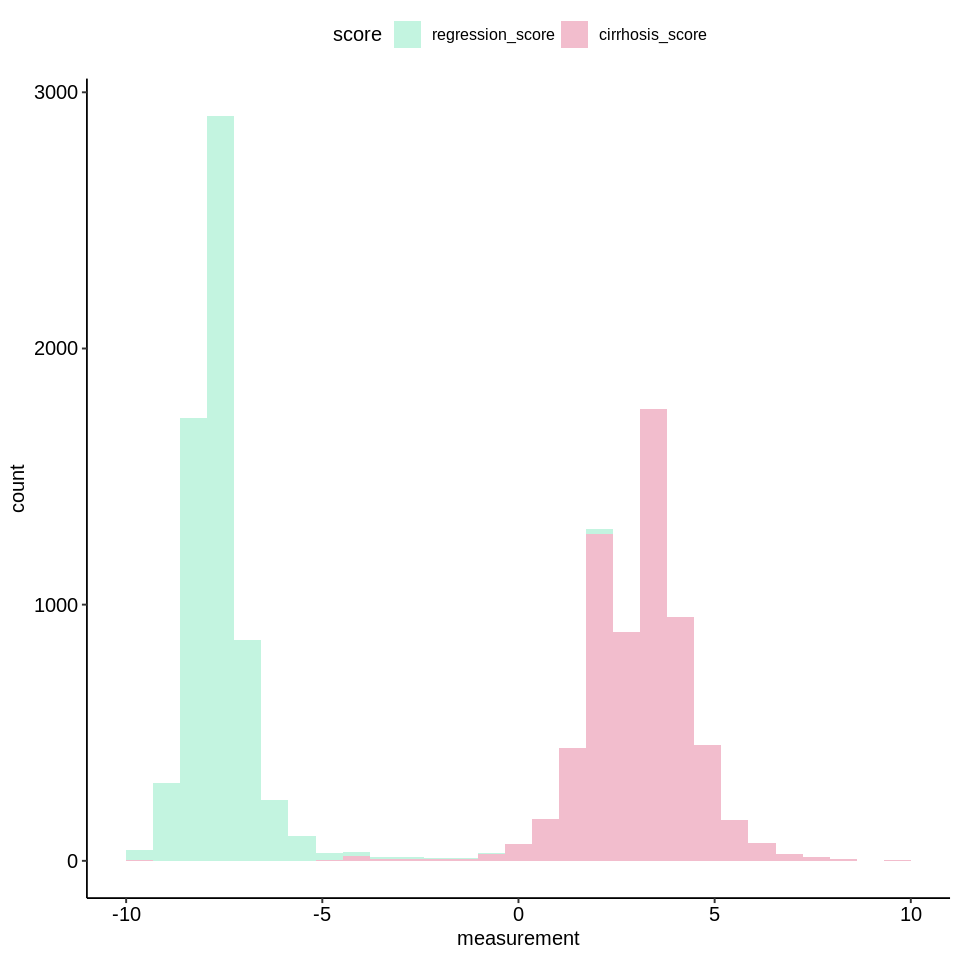

In [110]:
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot((all_df %>% tidyr::gather(., score, measurement, regression_score:cirrhosis_score, factor_key = TRUE)), 
        aes(x=measurement)) + 
        geom_histogram(alpha = .35, aes(fill = score)) + 
#        geom_density(alpha = 0.2) + 
        ggpubr::theme_pubr() +
        scale_fill_manual(values=c("#55dfa7", "#da4370")) 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 19599 rows containing non-finite values (`stat_bin()`)."


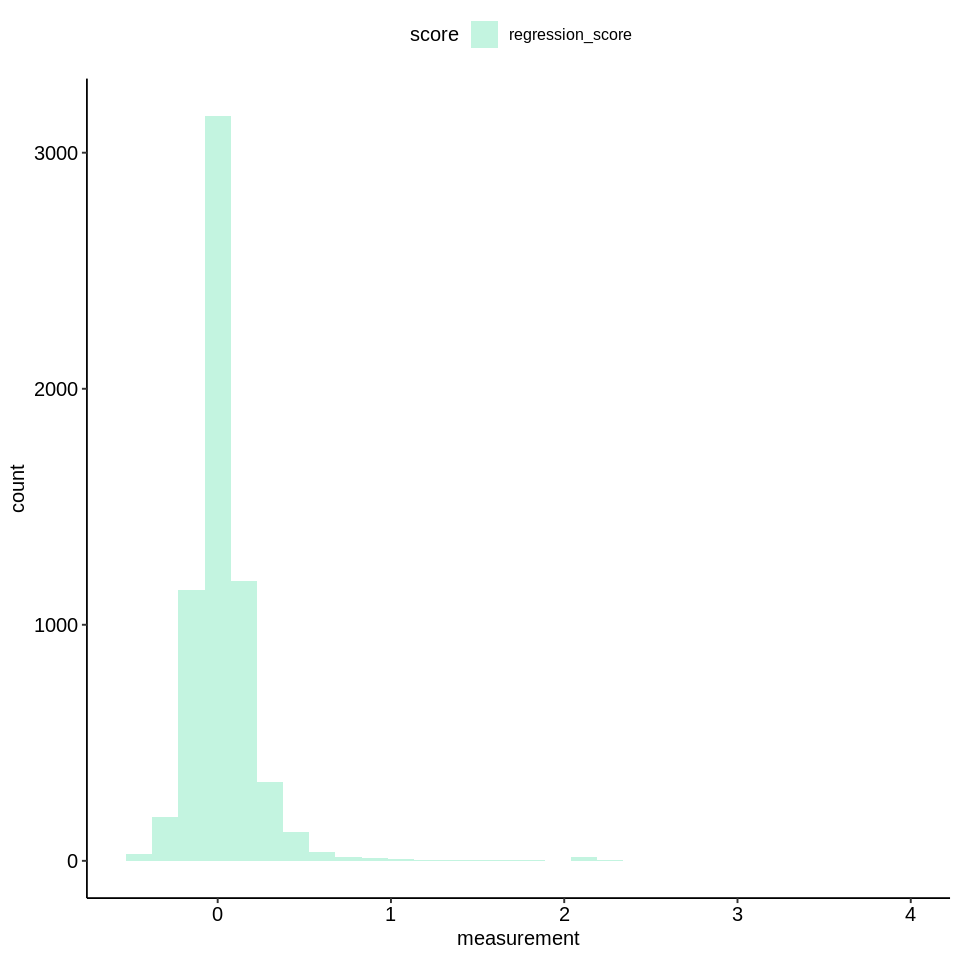

In [125]:
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(all_df_plot_reg, 
        aes(x=measurement)) + 
        geom_histogram(alpha = .35, aes(fill = score)) + 
#        geom_density(alpha = 0.2) + 
        ggpubr::theme_pubr() +
        scale_fill_manual(values=c("#55dfa7", "#da4370"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 19495 rows containing non-finite values (`stat_bin()`)."


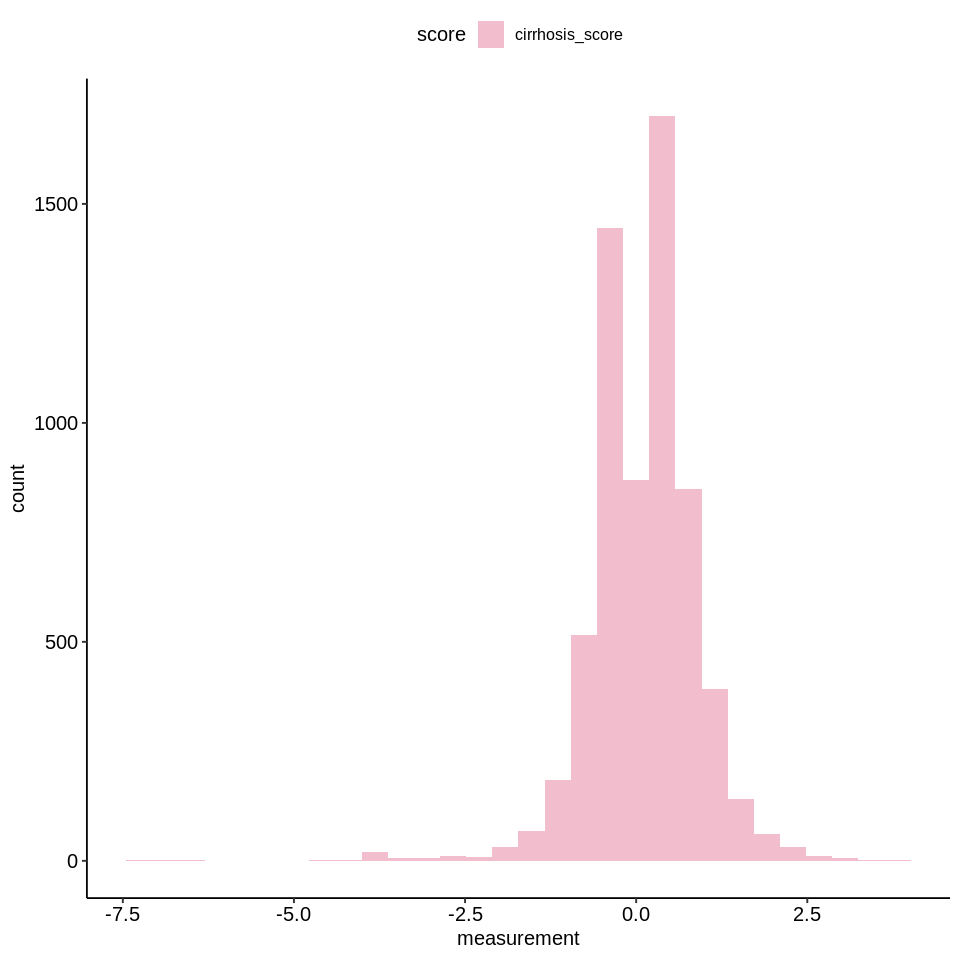

In [66]:
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(all_df_plot_cir, 
        aes(x=measurement)) + 
        geom_histogram(alpha = .35, aes(fill = score)) + 
#        geom_density(alpha = 0.2) + 
        ggpubr::theme_pubr() +
        scale_fill_manual(values=c("#da4370"))

### FGSEA & Heatmap

In [67]:
reg_df_top_20 <- reg_df_unscaled %>% arrange(desc(regression_score)) %>% top_frac(.2, wt = regression_score)
reg_df_bot_20 <- reg_df_unscaled %>% arrange(desc(regression_score)) %>% top_frac(-.2, wt = regression_score)
reg_df_mid <- reg_df_unscaled %>% filter(!gene %in% c(reg_df_bot_20$gene, reg_df_top_20$gene))

cir_df_top_20 <- cir_df_unscaled %>% arrange(desc(cirrhosis_score)) %>% top_frac(.2, wt = cirrhosis_score)
cir_df_bot_20 <- cir_df_unscaled %>% arrange(desc(cirrhosis_score)) %>% top_frac(-.2, wt = cirrhosis_score)
cir_df_mid <- cir_df_unscaled %>% filter(!gene %in% c(reg_df_bot_20$gene, cir_df_bot_20$gene))

In [68]:
ranks_reg_top_20 <- reg_df_top_20 %>% select(gene, regression_score) %>% tibble::deframe()
ranks_reg_bot_20 <- reg_df_bot_20 %>% select(gene, regression_score) %>% tibble::deframe()
reg_df_mid <- reg_df_mid %>% select(gene, regression_score) %>% tibble::deframe()

ranks_cir_top_20 <- cir_df_top_20 %>% select(gene, cirrhosis_score) %>% tibble::deframe()
ranks_cir_bot_20 <- cir_df_bot_20 %>% select(gene, cirrhosis_score) %>% tibble::deframe()
cir_df_mid <- cir_df_mid %>% select(gene, cirrhosis_score) %>% tibble::deframe()

In [ ]:
pathways <- gmtPathways("99_technical/m2.cp.wikipathways.v2023.1.Mm.symbols.gmt")
fgseaRes_reg_top <- fgsea(pathways=pathways, stats=ranks_cir_bot_20)
fgseaRes_reg_bot <- fgsea(pathways=pathways, stats=ranks_reg_bot_20)
fgseaRes_reg_mid <- fgsea(pathways=pathways, stats=reg_df_mid)

fgseaRes_cir_top <- fgsea(pathways=pathways, stats=ranks_cir_top_20)
fgseaRes_cir_bot <- fgsea(pathways=pathways, stats=ranks_cir_bot_20)
fgseaRes_cir_mid <- fgsea(pathways=pathways, stats=cir_df_mid)


fgseaRes_df_reg_top <- fgseaRes_reg_top %>% as.data.frame() %>% arrange(desc(NES)) %>% 
  dplyr::select(-leadingEdge, -ES) %>% arrange(padj)
fgseaRes_df_reg_bot <- fgseaRes_reg_bot %>% as.data.frame() %>% arrange(desc(NES)) %>% 
  dplyr::select(-leadingEdge, -ES) %>% arrange(padj)
fgseaRes_df_reg_mid <- fgseaRes_reg_mid %>% as.data.frame() %>% arrange(desc(NES)) %>% 
  dplyr::select(-leadingEdge, -ES) %>% arrange(padj) 

fgseaRes_df_cir_top <- fgseaRes_cir_top %>% as.data.frame() %>% arrange(desc(NES)) %>% 
  dplyr::select(-leadingEdge, -ES) %>% arrange(padj)
fgseaRes_df_cir_bot <- fgseaRes_cir_bot %>% as.data.frame() %>% arrange(desc(NES)) %>% 
  dplyr::select(-leadingEdge, -ES) %>% arrange(padj)
fgseaRes_df_cir_mid <- fgseaRes_cir_mid %>% as.data.frame() %>% arrange(desc(NES)) %>% 
  dplyr::select(-leadingEdge, -ES) %>% arrange(padj)

In [70]:
tmp_1 <- fgseaRes_df_cir_mid %>% filter(padj < 0.25) %>% select(pathway, NES) %>% rename(mid = NES)
tmp_2 <- fgseaRes_df_cir_top %>% filter(padj < 0.25) %>% select(pathway, NES) %>% rename(top = NES)
tmp_3 <- fgseaRes_df_cir_bot %>% filter(padj < 0.25) %>% select(pathway, NES) %>% rename(bot = NES)
tmp_4 <- merge(tmp_1, tmp_2, by = "pathway", all = T) %>% merge(., tmp_3, by = "pathway", all = T)

tmp_5 <- fgseaRes_df_reg_mid %>% filter(padj < 0.25) %>% select(pathway, NES) %>% rename(mid = NES)
tmp_6 <- fgseaRes_df_reg_top %>% filter(padj < 0.25) %>% select(pathway, NES) %>% rename(top = NES)
tmp_7 <- fgseaRes_df_reg_bot %>% filter(padj < 0.25) %>% select(pathway, NES) %>% rename(bot = NES)
tmp_8 <- merge(tmp_5, tmp_6, by = "pathway", all = T) %>% merge(., tmp_7, by = "pathway", all = T)

In [71]:
tmp_98 <- merge(tmp_2, tmp_3, by = "pathway", all = T) 
tmp_99 <- merge(tmp_6, tmp_7, by = "pathway", all = T) 


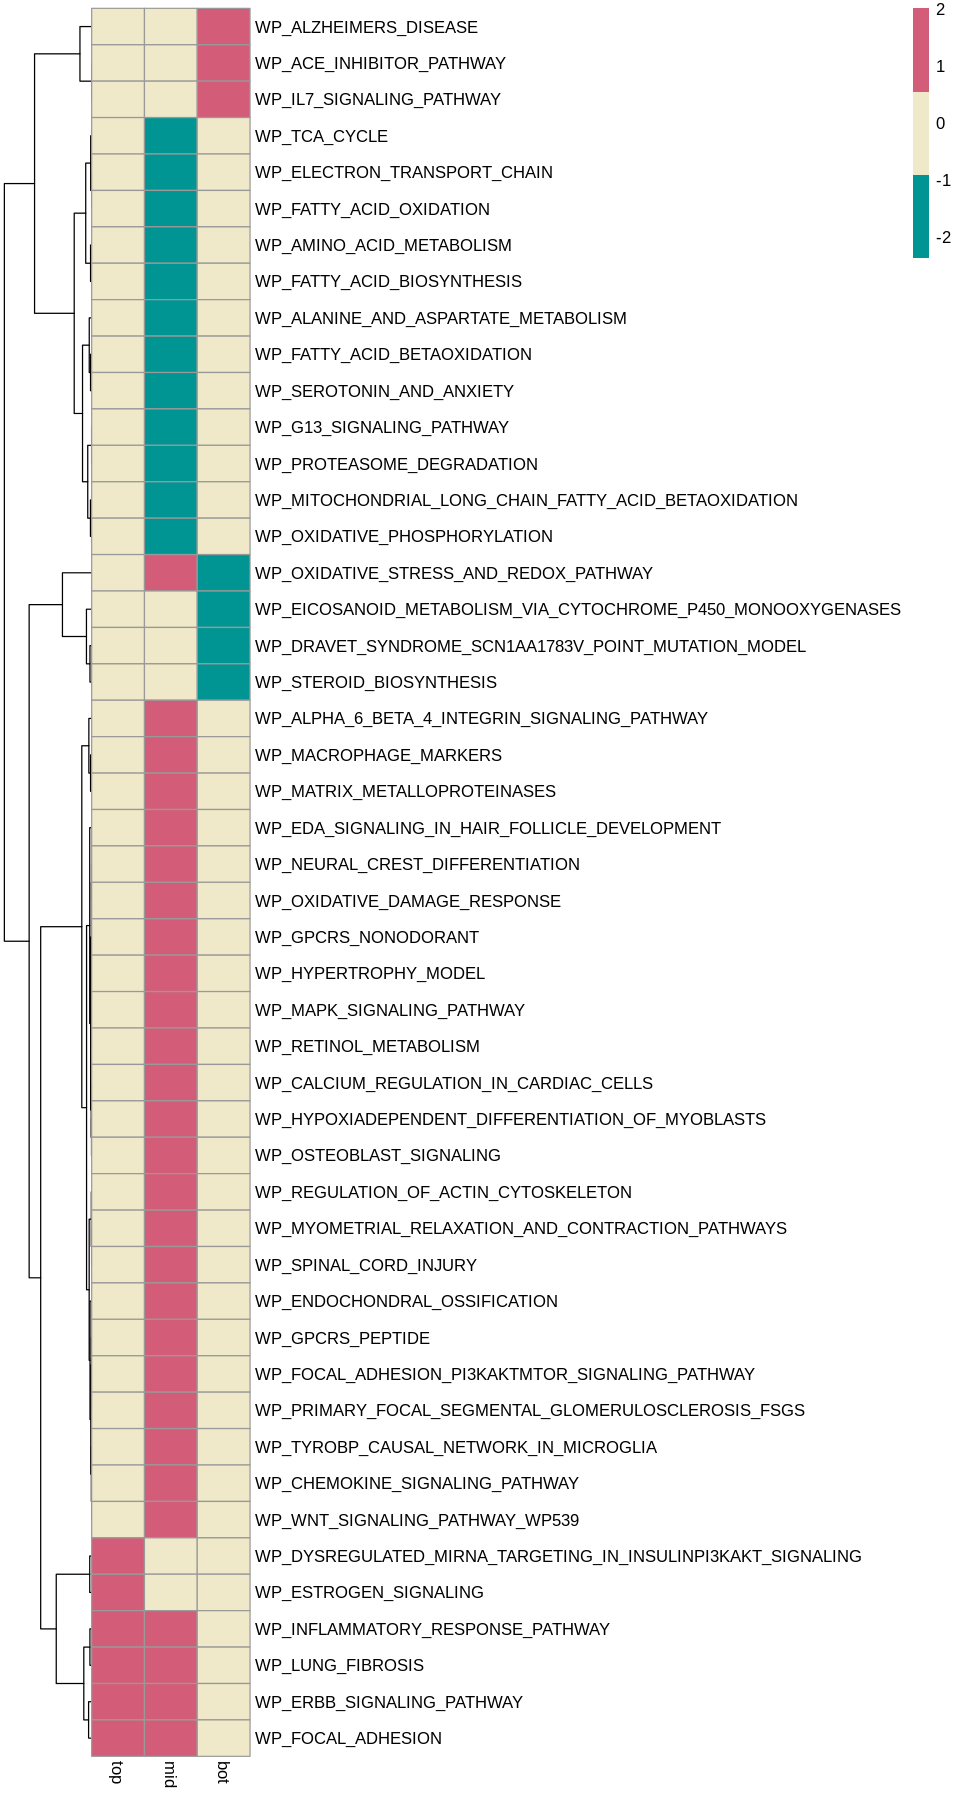

In [72]:
options(repr.plot.width = 8, repr.plot.height = 15)
tmp_4 %>% replace(is.na(.), 0) %>% tibble::column_to_rownames("pathway") %>% 
            relocate(top, mid, bot) %>% as.matrix() %>% 
            pheatmap::pheatmap(color = hcl.colors(3, "TealRose"), rev = FALSE, cluster_cols = FALSE)

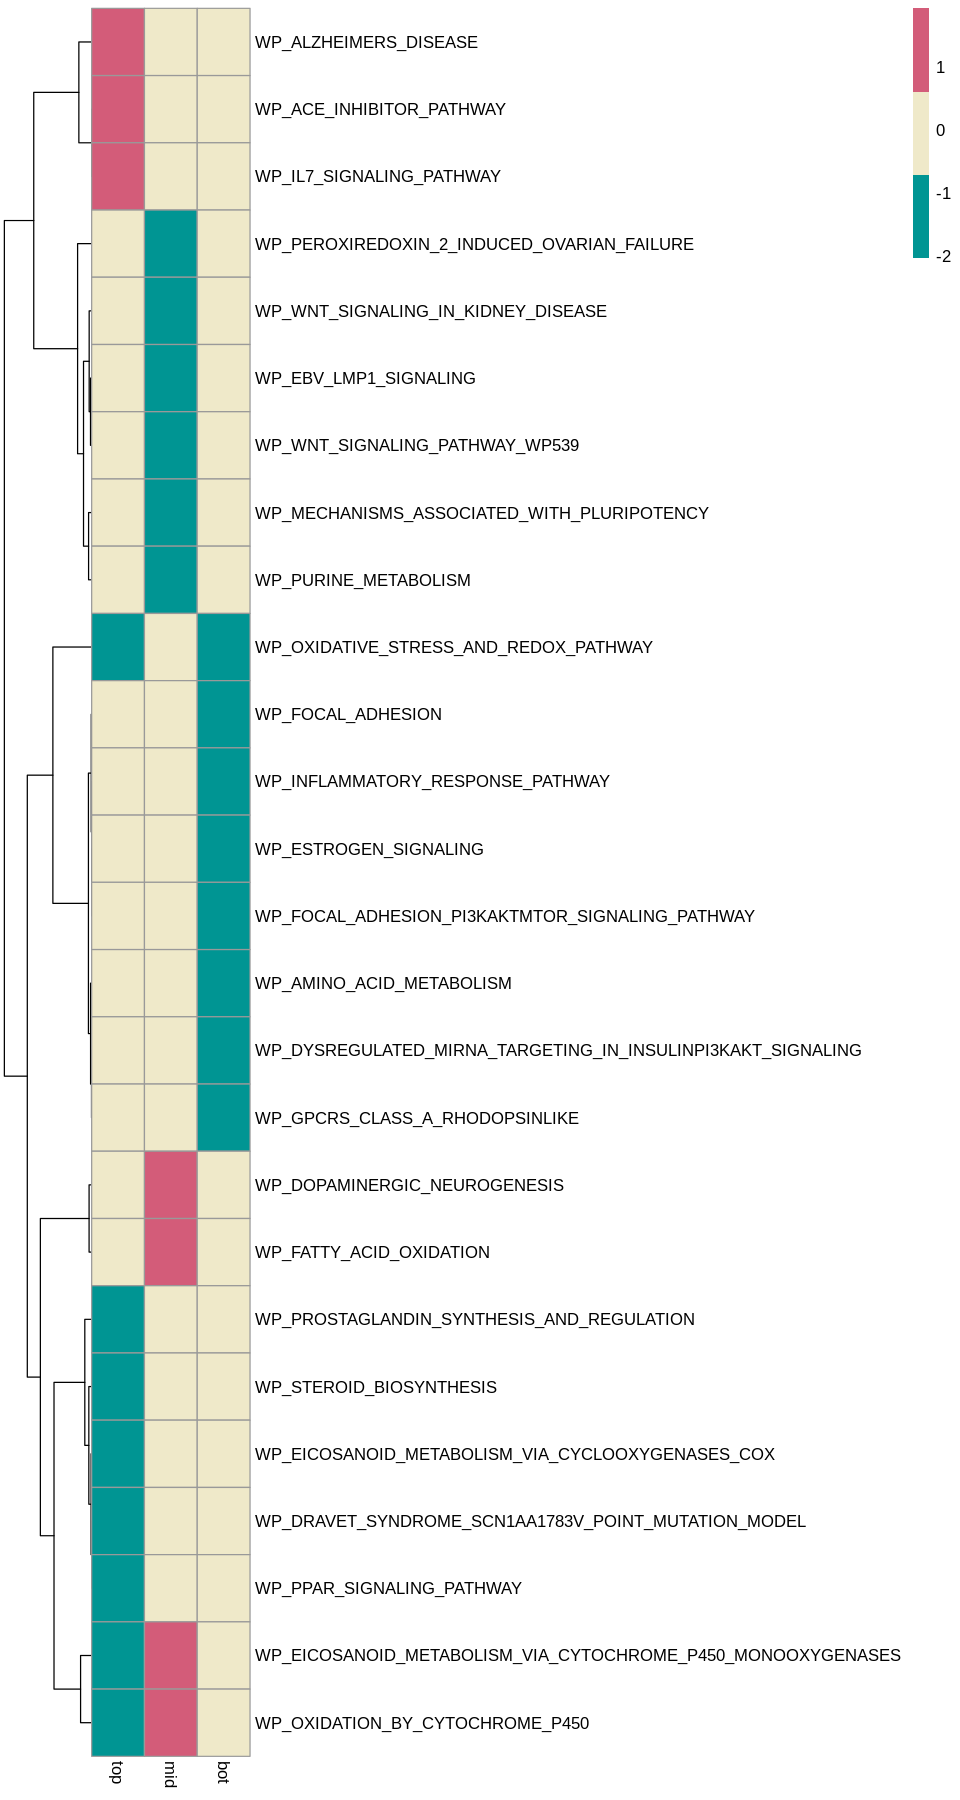

In [73]:
options(repr.plot.width = 8, repr.plot.height = 15)
tmp_8 %>% replace(is.na(.), 0) %>% tibble::column_to_rownames("pathway") %>% 
            relocate(top, mid, bot) %>% as.matrix() %>% 
            pheatmap::pheatmap(color = hcl.colors(3, "TealRose"), rev = FALSE, cluster_cols = FALSE)

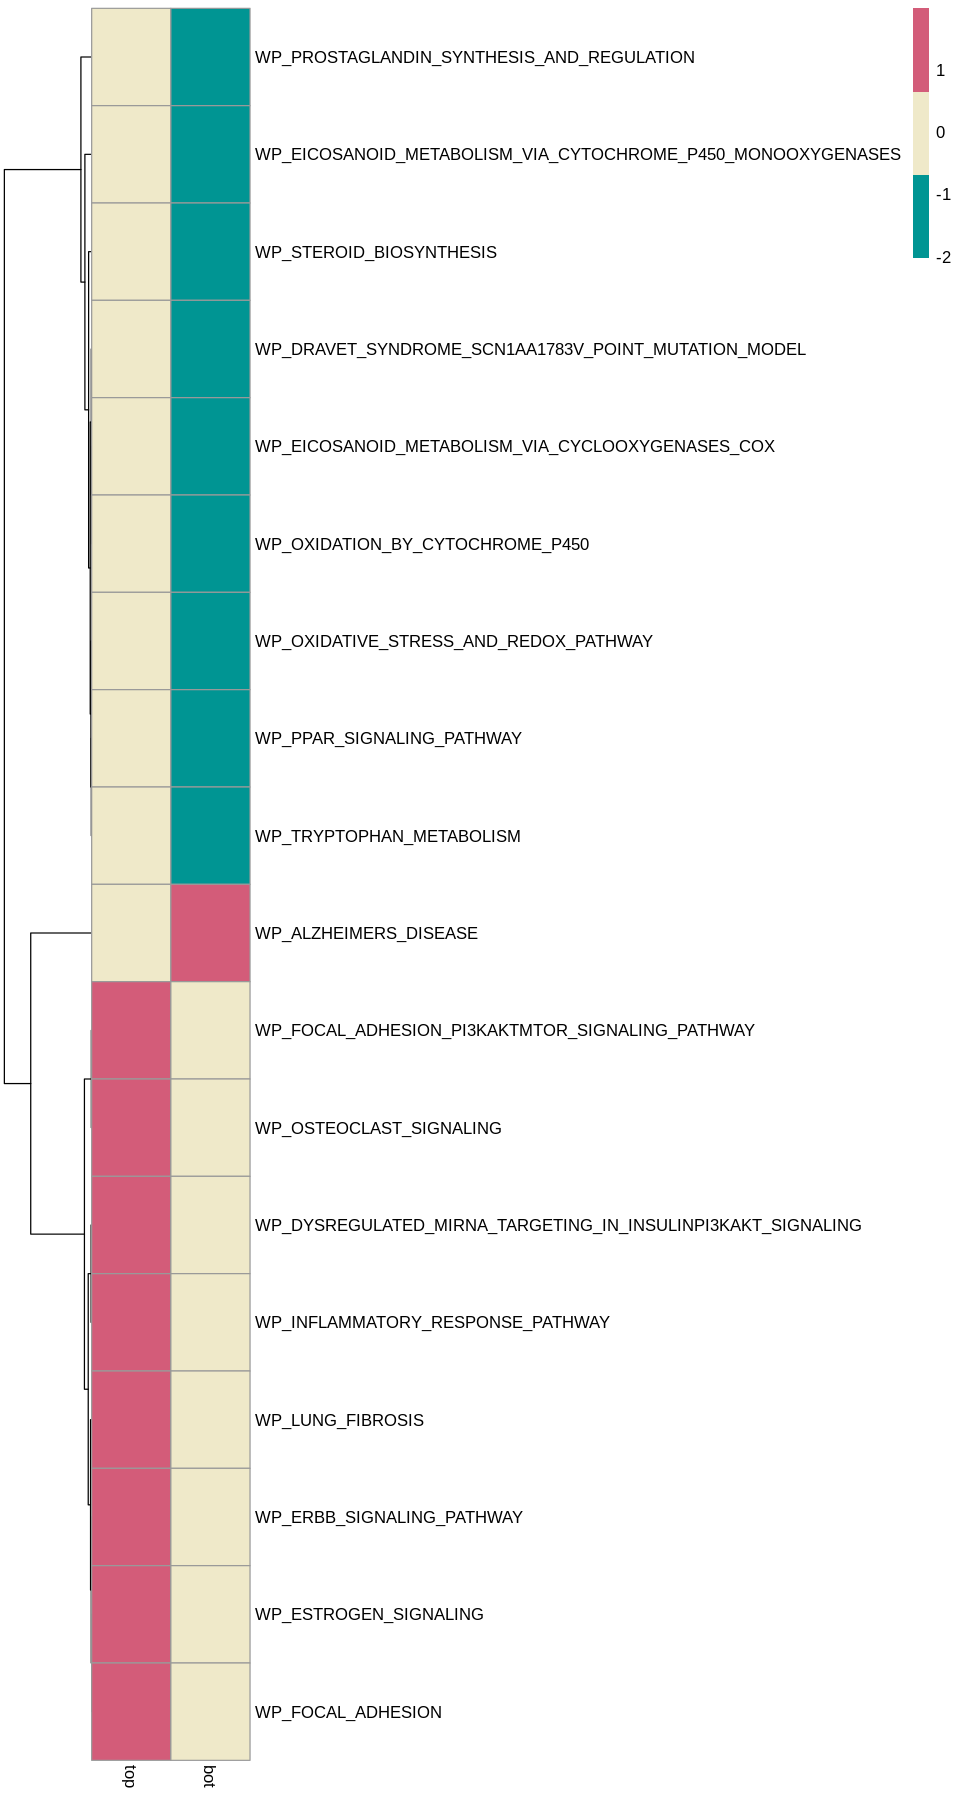

In [39]:
options(repr.plot.width = 8, repr.plot.height = 15)
tmp_98 %>% replace(is.na(.), 0) %>% tibble::column_to_rownames("pathway") %>% 
            relocate(top, bot) %>% as.matrix() %>% 
            pheatmap::pheatmap(color = hcl.colors(3, "TealRose"), rev = FALSE, cluster_cols = FALSE)

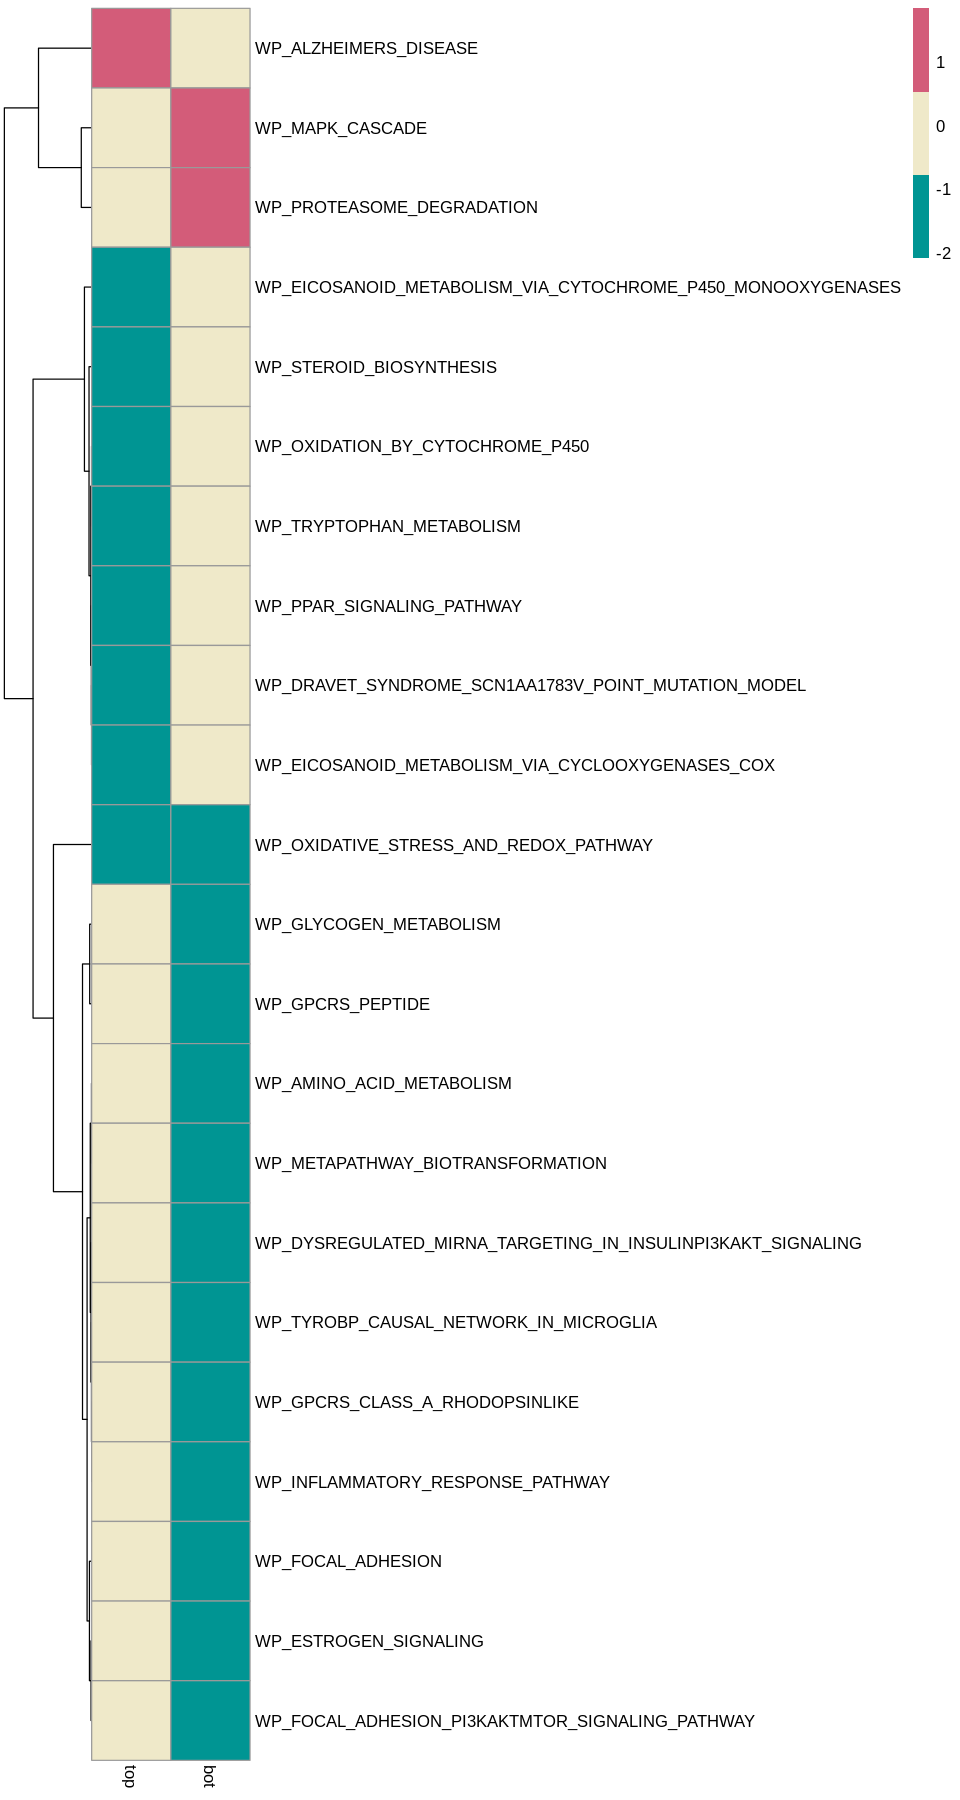

In [40]:
options(repr.plot.width = 8, repr.plot.height = 15)
tmp_99 %>% replace(is.na(.), 0) %>% tibble::column_to_rownames("pathway") %>% 
            relocate(top, bot) %>% as.matrix() %>% 
            pheatmap::pheatmap(color = hcl.colors(3, "TealRose"), rev = FALSE, cluster_cols = FALSE)

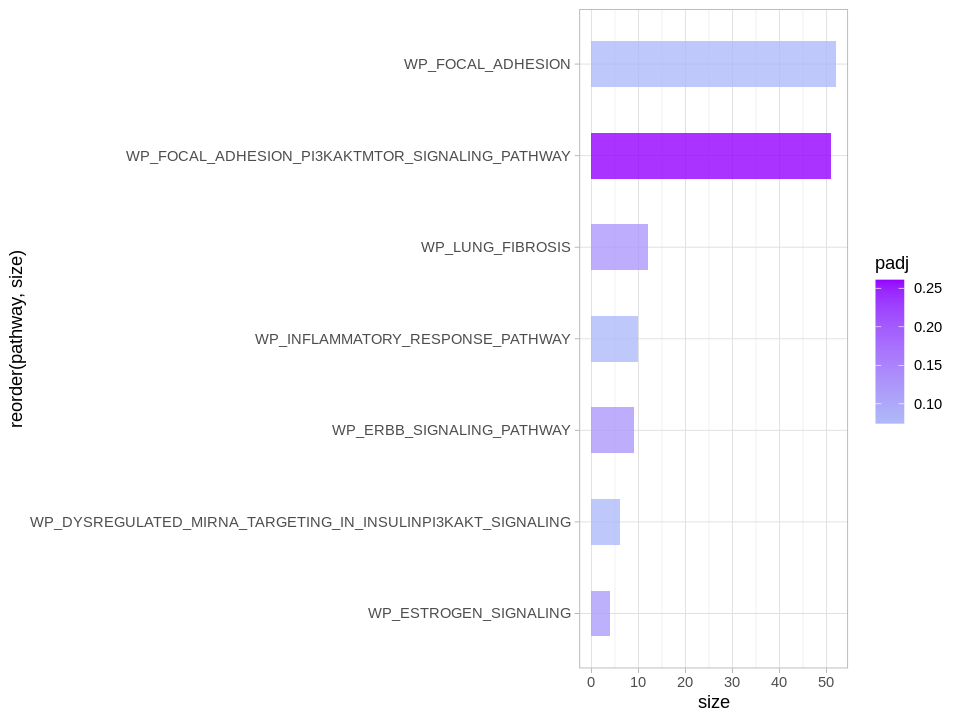

In [82]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.point.size = 16)
ggplot((fgseaRes_df_cir_top %>% filter(padj < 0.30) %>% arrange(desc(size))), 
    aes(x = reorder(pathway, size), y = size, fill = padj)) +
    geom_bar(stat ="identity", width = 0.5, alpha = 0.8) +
    coord_flip() +
 #   labs(x="Pathways", y="Number of genes", fill="Adjusted P-value (log10)", title = paste0("Pathway enrichment using ", database)) +
    theme(axis.text=element_text(size=20)) + 
    theme(legend.position="none") +
    theme(axis.text.x = element_text(color="black", 
                            size=20),
            axis.text.y = element_text(color="black", 
                            size=20)) +
    theme_light() + scale_fill_gradient(
    low = "#AEBAF8", 
    high = "#9600FF"
    )

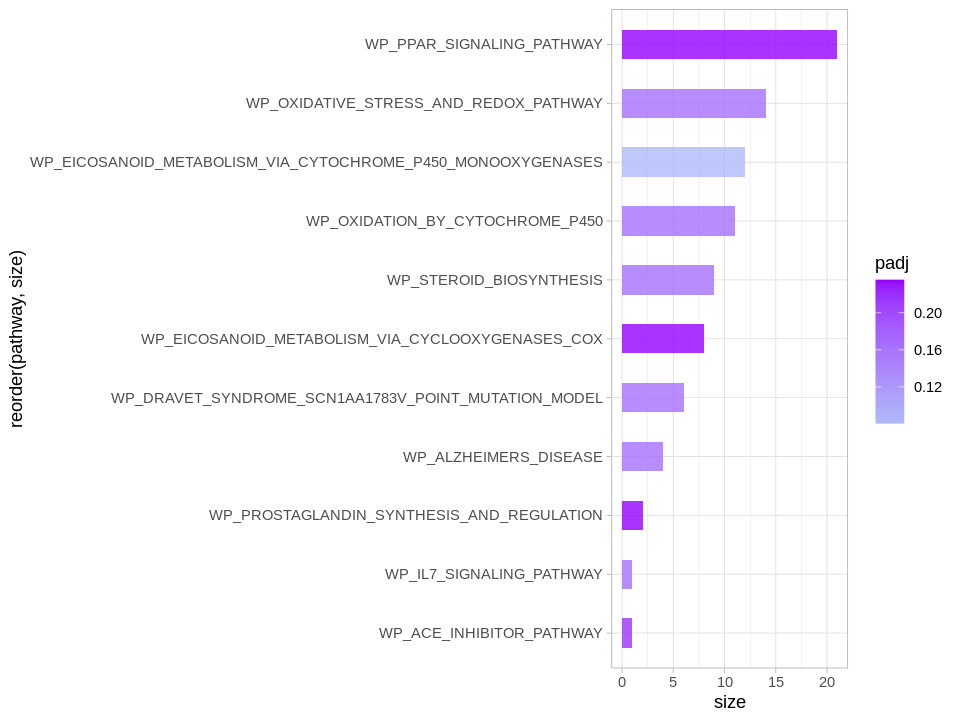

In [84]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.point.size = 16)
ggplot((fgseaRes_df_reg_top %>% filter(padj < 0.25) %>% arrange(desc(size))), 
    aes(x = reorder(pathway, size), y = size, fill = padj)) +
    geom_bar(stat ="identity", width = 0.5, alpha = 0.8) +
    coord_flip() +
 #   labs(x="Pathways", y="Number of genes", fill="Adjusted P-value (log10)", title = paste0("Pathway enrichment using ", database)) +
    theme(axis.text=element_text(size=20)) + 
    theme(legend.position="none") +
    theme(axis.text.x = element_text(color="black", 
                            size=20),
            axis.text.y = element_text(color="black", 
                            size=20)) +
    theme_light() + scale_fill_gradient(
    low = "#AEBAF8", 
    high = "#9600FF"
    )

In [90]:
tmp <- fgseaRes_reg_top %>% filter(padj < 0.25) %>% arrange(desc(size)) %>% filter(pathway == "WP_ALZHEIMERS_DISEASE")
tmp$leadingEdge

[[1]]
[1] "Plcb1"   "Casp7"   "Cacna1d" "Itpr2"

## Outputs

In [30]:
write.csv(as.data.frame(groups_intercept), 
          file="03_outputs/03_2/groups_intercept_ltr.csv")
write.csv(as.data.frame(groups_full), 
          file="03_outputs/03_2/groups_full_ltr.csv")

In [44]:
write.csv(as.data.frame(up_down$genes), 
          file="03_outputs/03_2/ltr_genes_intercept_up_down.csv")
write.csv(as.data.frame(up_up$genes), 
          file="03_outputs/03_2/ltr_genes_intercept_up_up.csv")
write.csv(as.data.frame(down_up$genes), 
          file="03_outputs/03_2/ltr_genes_intercept_down_up.csv")
write.csv(as.data.frame(down_down$genes), 
          file="03_outputs/03_2/ltr_genes_intercept_down_down.csv")

In [19]:
write.csv(as.data.frame(sigtmp_genes_full), 
          file="03_outputs/03_2/de_full_ltr.csv")

In [153]:
write.csv(cir_score, file="03_outputs/03_2/genes_cirrhosis_score.csv")
write.csv(reg_score, file="03_outputs/03_2/genes_regression_score.csv")

In [52]:
write.csv(all_df, file="03_outputs/03_2/scores_merged_dataframe.csv")